In [1]:
import tensorflow as tf

import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from scipy.stats import multivariate_normal as mvn

import matplotlib.pyplot as plt

In [2]:
dist = mvn(mean = np.array([2,3]), cov = np.diag([3,0.01]))

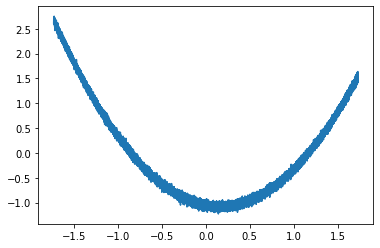

In [3]:
N = 50000
N = 50000
x_dim = 1
y_dim = 1
noise_std_true = 0.5
x = np.linspace(-10., 100., N)[None].T
x = np.float32(x)
b_true = np.random.randn(y_dim).astype(np.float32)   
w_true = np.random.randn(x_dim, y_dim).astype(np.float32) 

noise = noise_std_true * np.random.randn(N,y_dim).astype(np.float32)
y = np.matmul((x-50)**2, w_true)/100. + b_true + noise
x = x - np.mean(x)
x /= np.std(x)
y = y - np.mean(y)
y /= np.std(y)
plt.plot(x, y)

In [4]:
radius = np.abs(np.random.normal(loc=0., scale=1., size=(N//2,1)))
theta = np.random.uniform(low=0., high=2*np.pi, size=(N//2,1))
x1 = radius * np.cos(theta)
y1 = radius * np.sin(theta)

radius = np.abs(np.random.normal(loc=10., scale=1., size=(N//2,1)))
theta = np.random.uniform(low=0., high=2*np.pi, size=(N//2,1))
x2 = radius * np.cos(theta)
y2 = radius * np.sin(theta)



x = np.vstack([x1, x2])
y = np.vstack([y1, y2])

x = x - np.mean(x)
x /= np.std(x)
y = y - np.mean(y)
y /= np.std(y)

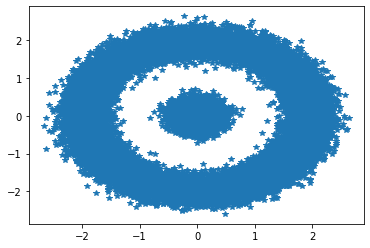

In [5]:
plt.plot(x, y, '*')

In [6]:
samples = np.hstack([x, y])

In [7]:
Dx = 2

In [8]:
def sample_batch(batch_size = 32):
    idx = np.random.randint(low = 0, high = 50000, size = batch_size)
    return samples[idx]

#### Define generator

In [59]:
z_dim = 4

In [60]:
generator = Sequential([
    Dense(128, 'relu', kernel_initializer='glorot_normal', bias_initializer='zeros',input_shape=(z_dim,)), 
    Dense(128, 'relu',kernel_initializer='glorot_normal', bias_initializer='zeros'), 
    Dense(Dx, kernel_initializer='glorot_normal', bias_initializer='zeros')
])

#### Define discriminator

In [61]:
discriminator = Sequential([
    Dense(128, 'relu',kernel_initializer='glorot_normal', bias_initializer='zeros', input_shape=(Dx,)),
    Dense(128, 'relu',kernel_initializer='glorot_normal', bias_initializer='zeros',),
    Dense(1,kernel_initializer='glorot_normal', bias_initializer='zeros',)
])

#### Define the training functions

In [62]:
optimizer_gen = tf.keras.optimizers.RMSprop(lr=0.0001)
optimizer_disc = tf.keras.optimizers.RMSprop(lr=0.0001)

In [63]:
from IPython.core import display


In [64]:
@tf.function
def train_discriminator(x_real, x_fake):
    n = x_real.shape[0]
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(discriminator(x_real) - discriminator(x_fake))
        
    gradients = tape.gradient(loss, discriminator.trainable_variables)
    optimizer_disc.apply_gradients(zip(gradients, discriminator.trainable_variables))
    for i, weights in enumerate(discriminator.trainable_variables):
        discriminator.trainable_variables[i].assign(tf.clip_by_value(weights, -0.01, 0.01))
    return loss, gradients

In [65]:
@tf.function
def train_generator(z):
    n = z.shape[0]
    with tf.GradientTape() as tape:
        x_fake = generator(z)
        loss = - tf.reduce_mean(discriminator(x_fake))
        
    gradients = tape.gradient(loss, generator.trainable_variables)
    optimizer_gen.apply_gradients(zip(gradients, generator.trainable_variables))
    return loss, gradients

In [66]:
batch = 64

In [ ]:
plotting = True
avgs_real = []
avgs_fake = []
for epoch in range(100000):
    try:
        if epoch < 25 or epoch % 500 == 0:
            n_critic = 100
        else:
            n_critic = 5

        #train discriminator
        for i in range(n_critic):
            x_real = sample_batch(batch)
            z = tf.random.normal((batch, z_dim))
            x_fake = generator(z)
            loss_disc, grad_disc = train_discriminator(x_real, x_fake)

        #train generator
        z = tf.random.normal((batch, z_dim))
        loss_gen, grad_gen = train_generator(z)

        display.clear_output(wait=True)
        avg_real = discriminator(x_real).numpy().mean()
        avg_fake = discriminator(x_fake).numpy().mean()
        print("Epoch: {}, Avg real: {:.4f}, Avg fake: {:.4f}".format(epoch, avg_real, avg_fake))    

        avgs_real.append(avg_real)
        avgs_fake.append(avg_fake)

        if plotting and epoch % 100 == 0:
            plt.clf()
            fig,ax = plt.subplots()
            ax.plot(samples[:,0], samples[:,1], "k.")
            z = tf.random.normal((50000, z_dim))
            x_test = generator(z)
            ax.plot(x_test[:,0], x_test[:,1], "b.", alpha=0.1)
            plt.axis('equal')
            plt.savefig('images/epoch{}'.format(epoch))
        
    except KeyboardInterrupt:
            break

Epoch: 14859, Avg real: -0.0008, Avg fake: -0.0008


<Figure size 432x288 with 0 Axes>

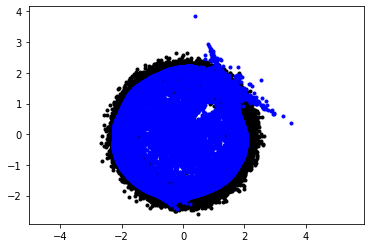

In [46]:
plt.clf()
fig,ax = plt.subplots()
ax.plot(samples[:,0], samples[:,1], "k.")
z = tf.random.normal((50000, z_dim))
x_test = generator(z)
ax.plot(x_test[:,0], x_test[:,1], "b.", alpha=1)
plt.axis('equal')
plt.savefig('images/epoch{}'.format(epoch))

